In [1]:
import pyanitools as pyt
import pyaniasetools as aat
import hdnntools as hdt
import numpy as np

import matplotlib.pyplot as plt
import aniensemblestats as ens

import os
import pandas as pd

import time

import seaborn as sns
print(pd.__version__)

#import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
cm = sns.light_palette("green", as_cmap=True)

0.21.0


In [2]:
tex_store = '/home/jujuman/Dropbox/ANAKIN-ME-RESEARCH/PUBLICATION-ActiveLearning/tables/MDBenchmark_ANI-9.0.5.tex'
xls_store = '/home/jujuman/Dropbox/ANAKIN-ME-RESEARCH/PUBLICATION-ActiveLearning/tables/MDBenchmark_ANI-9.0.5.xlsx'
frc_xlsx = '/home/jujuman/Dropbox/ANAKIN-ME-RESEARCH/PUBLICATION-ActiveLearning/tables/MDBenchmark_frcErrorperMolecule_ANI-9.0.5.xlsx'
ani_version = 'ANI-9.0.5'

fdir_wb97 = '/home/jujuman/Research/extensibility_test_sets/COMP6v1/ani_md_benchmark/data_big/data/'
fdir_dftb = '/home/jujuman/Research/extensibility_test_sets/COMP6v1/ani_md_benchmark/test_dftb/data/'
fdir_pm6 = '/home/jujuman/Research/extensibility_test_sets/COMP6v1/ani_md_benchmark/test_pm6/data/'

wkdir = '/home/jujuman/Research/DataReductionMethods/train_test/ANI-9.0.4_netarch7'
#wkdir = '/home/jujuman/Research/ANI-validation/'
cnstfile = wkdir + '/rHCNO-4.6A_16-3.1A_a4-8.params'
saefile  = wkdir + '/sae_6-31gd.dat'
nnfdir   = wkdir + '/train'
Nn = 5

In [3]:
# Define the conformer cross validator class
anicv = aat.anicrossvalidationmolecule(cnstfile,saefile,nnfdir,Nn,gpuid=0)

In [4]:
files = os.listdir(fdir_dftb)

stats1 = dict()
stats2 = dict()
stats3 = dict()
stats4 = dict()
style_F = dict()
Forces = dict({'ANI':[],
               'DFT':[],
               'DFTB':[],
               'PM6':[],})

forces = dict({'ANI':{},
               'DFT':{},
               'DFTB':{},
               'PM6':{},})


denegy = dict({'ANI':{},
               'DFT':{},
               'DFTB':{},
               'PM6':{},})

enegy = dict({'ANI':{},
               'DFT':{},
               'DFTB':{},
               'PM6':{},})

for f in files:
    name = f.split('_')[0]
    data_wb97 = hdt.readncdatall(fdir_wb97+f)
    data_dftb = hdt.readncdatall(fdir_dftb+f)
    data_pm6 = hdt.readncdatall(fdir_pm6+f)
    
    
    start = time.time()
    Eani, Fani, Sani = anicv.compute_stats_multi_molecule(X=data_wb97['coordinates'],S=data_wb97['species'])
    end = time.time()
    comp_time = end - start
    
    Sani = np.std(Eani,axis=0)
    print(Sani.shape)
    Eani = np.mean(Eani,axis=0)
    Fani = np.mean(Fani,axis=0)
    
    Ewb97 = hdt.hatokcal*data_wb97['energies']
    Fwb97 = hdt.hatokcal*data_wb97['forces']
    
    Edftb = hdt.hatokcal*data_dftb['energies']
    Fdftb = hdt.hatokcal*data_dftb['forces']

    Epm6 = hdt.hatokcal*data_pm6['energies']
    Fpm6 = hdt.hatokcal*data_pm6['forces']
    
    print(name,Ewb97.size,' Time: ', comp_time)
    #print(data['species'])
    #print((Fani-Fdft)[0][12])
    #print(Fani[0][12])
    #print(Fdft[0][12])

    frc_error = dict()
    dF = np.linalg.norm(Fani - Fwb97,axis=2)
    #dF = np.mean(dF,axis=1)
    print(dF.shape)
    for j,F in enumerate(dF):
        Fstore = dict()
        for i,(s,x) in enumerate(zip(data_wb97['species'],F)):
            Fstore[str(i).zfill(3)+' '+s] = x
        #Fstore['Total'] = np.mean(dF,axis=1)
        #print(np.mean(dF,axis=1).shape)
        frc_error[str(j).zfill(3)] = pd.Series(Fstore)
    style_F[name] = pd.DataFrame(frc_error).transpose().style.background_gradient(cmap=cm)
    
    #np.random.shuffle(Fwb97)
    
    Fani = Fani.flatten()
    Fwb97 = Fwb97.flatten()
    Fdftb = Fdftb.flatten()
    Fpm6 = Fpm6.flatten()
    
    Forces['ANI'].append(Fani)
    Forces['DFT'].append(Fwb97)
    Forces['DFTB'].append(Fdftb)
    Forces['PM6'].append(Fpm6)

    forces['ANI'].update({name : Fani})
    forces['DFT'].update({name : Fwb97})
    forces['DFTB'].update({name : Fdftb})
    forces['PM6'].update({name : Fpm6})
    
    dEani = hdt.calculatedmat(Eani)
    dEwb97 = hdt.calculatedmat(Ewb97)
    dEdftb = hdt.calculatedmat(Edftb)
    dEpm6 = hdt.calculatedmat(Epm6)
    
    denegy['ANI'].update({name : dEani})
    denegy['DFT'].update({name : dEwb97})
    denegy['DFTB'].update({name : dEdftb})
    denegy['PM6'].update({name : dEpm6})
    
    enegy['ANI'].update({name : Eani})
    enegy['DFT'].update({name : Ewb97})
    enegy['DFTB'].update({name : Edftb})
    enegy['PM6'].update({name : Epm6})
    
    Na = len(data_wb97['species'])
    
    stats1[name] = pd.Series({'$\mathrm{Atoms}$': int(Na),
                              '$\mathrm{E_{MAE}}$'   : hdt.calculatemeanabserror(Eani,Ewb97),
                              '$\mathrm{E_{RMS}}$'   : hdt.calculaterootmeansqrerror(Eani,Ewb97),
                              '$\mathrm{E_{range}}$'   : np.abs(Ewb97.max()-Ewb97.min()),
                              '$\mathrm{\Delta E_{MAE}}$'  : hdt.calculatemeanabserror(dEani,dEwb97),
                              '$\mathrm{\Delta E_{RMS}}$'  : hdt.calculaterootmeansqrerror(dEani,dEwb97),
                              '$\mathrm{\Delta E_{range}}$'   : np.abs(dEwb97.max()-dEwb97.min()),
                              '$\mathrm{F_{MAE}}$'   : hdt.calculatemeanabserror(Fani,Fwb97),
                              '$\mathrm{F_{RMS}}$'   : hdt.calculaterootmeansqrerror(Fani,Fwb97),
                              '$\mathrm{F_{range}}$'   : np.abs(Fwb97.max()-Fwb97.min()),
                              'time(ms)/mol' : 1000*comp_time/Ewb97.size,
                              })
    
    stats2[name] = pd.Series({'$\mathrm{Atoms}$': int(Na),
                              '$\mathrm{\Delta E_{MAE}^{DFTB}}$' : hdt.calculatemeanabserror(dEdftb,dEwb97),
                              '$\mathrm{\Delta E_{MAE}^{PM6}}$'  : hdt.calculatemeanabserror(dEpm6,dEwb97),
                              '$\mathrm{\Delta E_{MAE}^{ANI}}$'  : hdt.calculatemeanabserror(dEani,dEwb97),
                              '$\mathrm{\Delta E_{RMS}^{DFTB}}$' : hdt.calculaterootmeansqrerror(dEdftb,dEwb97),
                              '$\mathrm{\Delta E_{RMS}^{PM6}}$'  : hdt.calculaterootmeansqrerror(dEpm6,dEwb97),
                              '$\mathrm{\Delta E_{RMS}^{ANI}}$'  : hdt.calculaterootmeansqrerror(dEani,dEwb97),
                              '$\mathrm{F_{MAE}^{DFTB}}$'   : hdt.calculatemeanabserror(Fdftb,Fwb97),
                              '$\mathrm{F_{MAE}^{PM6}}$'   : hdt.calculatemeanabserror(Fpm6,Fwb97),
                              '$\mathrm{F_{MAE}^{ANI}}$'   : hdt.calculatemeanabserror(Fani,Fwb97),
                              '$\mathrm{F_{RMS}^{DFTB}}$'   : hdt.calculaterootmeansqrerror(Fdftb,Fwb97),
                              '$\mathrm{F_{RMS}^{PM6}}$'   : hdt.calculaterootmeansqrerror(Fpm6,Fwb97),
                              '$\mathrm{F_{RMS}^{ANI}}$'   : hdt.calculaterootmeansqrerror(Fani,Fwb97),
                              })
 
    stats4[name] = pd.Series({'$\mathrm{Atoms}$': int(Na),
                              '$\mathrm{E_{RMS}/ atom}$'   : hdt.calculaterootmeansqrerror(Eani/Na,Ewb97/Na),
                              '$\mathrm{E_{RMS}/ \sqrt{atom}}$'   : hdt.calculaterootmeansqrerror(Eani,Ewb97)/np.sqrt(Na),
                              '$\mathrm{\sigma / \sqrt{atom}}$'   : np.mean(Sani/np.sqrt(Na)),
                              '$\mathrm{\Delta E_{RMS}/ atom}$'  : hdt.calculaterootmeansqrerror(dEani,dEwb97)/Na,
                              '$\mathrm{\Delta E_{RMS}/ \sqrt{atom}}$'  : hdt.calculaterootmeansqrerror(dEani,dEwb97)/np.sqrt(Na),
                              '$\mathrm{F_{RMS}/ atom}$'   : hdt.calculaterootmeansqrerror(Fani,Fwb97)/Na,
                              '$\mathrm{F_{RMS}/ \sqrt{atom}}$'   : hdt.calculaterootmeansqrerror(Fani,Fwb97)/np.sqrt(Na),
                              })

    #for i,E in enumerate(Eani-Ewb97):
    #    print(' -',i,E)

    dErANI_MAE = hdt.calculatemeanabserror(dEani,dEwb97)
    dErDFTB_MAE = hdt.calculatemeanabserror(dEdftb,dEwb97)
    dErPM6_MAE = hdt.calculatemeanabserror(dEpm6,dEwb97)

    dErANI_RMS = hdt.calculaterootmeansqrerror(dEani,dEwb97)
    dErDFTB_RMS = hdt.calculaterootmeansqrerror(dEdftb,dEwb97)
    dErPM6_RMS = hdt.calculaterootmeansqrerror(dEpm6,dEwb97)
    
    FrANI_MAE = hdt.calculatemeanabserror(Fani,Fwb97)
    FrDFTB_MAE = hdt.calculatemeanabserror(Fdftb,Fwb97)
    FrPM6_MAE = hdt.calculatemeanabserror(Fpm6,Fwb97)

    FrANI_RMS = hdt.calculaterootmeansqrerror(Fani,Fwb97)
    FrDFTB_RMS = hdt.calculaterootmeansqrerror(Fdftb,Fwb97)
    FrPM6_RMS = hdt.calculaterootmeansqrerror(Fpm6,Fwb97)
    
    stats3[name] = pd.Series({#'$\mathrm{Atoms}$': str(int(Na)),
                              '$\mathrm{\Delta \Delta E_{MAE}^{DFTB}}$'  : dErDFTB_MAE-dErANI_MAE,
                              '$\mathrm{\Delta \Delta E_{MAE}^{PM6}}$'  : dErPM6_MAE-dErANI_MAE,
                              '$\mathrm{\Delta \Delta E_{RMS}^{DFTB}}$'  : dErDFTB_RMS-dErANI_RMS,
                              '$\mathrm{\Delta \Delta E_{RMS}^{PM6}}$'  : dErPM6_RMS-dErANI_RMS,
                              '$\mathrm{\Delta F_{MAE}^{DFTB}}$'   : FrDFTB_MAE-FrANI_MAE,
                              '$\mathrm{\Delta F_{MAE}^{PM6}}$'   : FrPM6_MAE-FrANI_MAE,
                              '$\mathrm{\Delta F_{RMS}^{DFTB}}$'   : FrDFTB_RMS-FrANI_RMS,
                              '$\mathrm{\Delta F_{RMS}^{PM6}}$'   : FrPM6_RMS-FrANI_RMS,
                              })

for k in Forces.keys():
    Forces[k] = np.concatenate(Forces[k])
    
edat1 = pd.DataFrame(stats1)
edat2 = pd.DataFrame(stats2)
edat3 = pd.DataFrame(stats3)
edat4 = pd.DataFrame(stats4)

edat4 = edat4.transpose()
edat4 = edat4.sort_values(['$\mathrm{Atoms}$'])
edat4 = edat4.transpose()

edat2['mean'] = edat2.mean(axis=1)
edat4['mean'] = edat4.mean(axis=1)

print(edat2['mean'])

edat1 = edat1.transpose()
edat2 = edat2.transpose()
edat3 = edat3.transpose()
edat4 = edat4.transpose()

(128,)
Atomoxetine 128  Time:  0.5098869800567627
(128, 40)
(128,)
Acetaminophen 128  Time:  0.34116649627685547
(128, 20)
(128,)
Tolterodine 128  Time:  0.6537084579467773
(128, 55)
(128,)
ChignolinNeutral 128  Time:  0.6905727386474609
(128, 149)
(127,)
Fentanyl 127  Time:  0.530238151550293
(127, 53)
(128,)
Caffeine 128  Time:  0.37500619888305664
(128, 24)
(128,)
TrpCage1L2Y 128  Time:  1.1514599323272705
(128, 312)
(128,)
Ranolazine 128  Time:  0.5434720516204834
(128, 64)
(128,)
Oseltamivir 128  Time:  0.5625920295715332
(128, 50)
(128,)
Salbutamol 128  Time:  0.5026099681854248
(128, 38)
(128,)
Retinol 128  Time:  0.5028443336486816
(128, 51)
(128,)
Atazanavir 128  Time:  0.6204795837402344
(128, 103)
(128,)
Lisdexamfetamine 128  Time:  0.4717061519622803
(128, 44)
(128,)
Capsaicin 128  Time:  0.4483046531677246
(128, 49)
$\mathrm{Atoms}$                   75.14
$\mathrm{F_{MAE}^{ANI}}$            2.49
$\mathrm{F_{MAE}^{DFTB}}$           4.51
$\mathrm{F_{MAE}^{PM6}}$            

In [5]:
#edat = pd.DataFrame(stats).transpose()
pd.set_option('expand_frame_repr', False)
edat1 = edat1.sort_values(['$\mathrm{Atoms}$'])
#edat2 = edat2.sort_values(['$\mathrm{Atoms}$'])
#edat3 = edat3.sort_values(['$\mathrm{Atoms}$'])

# Build latex document
header = r'\documentclass{article}'+'\n'+r'\usepackage{booktabs}'+'\n'+r'\usepackage[margin=0.5in]{geometry}'+'\n'+r'\begin{document}'+'\n'

begtab = r'\begin{table}'+'\n'+r'\tiny'+'\n'+r'\centering'+'\n'
endtab = r'\end{table}'+'\n'
enddoc = r'\end{document}'
with open(tex_store, "w") as text_file:
    text_file.write(header)
    text_file.write(begtab+r'\caption{'+ani_version+r'}'+'\n'+edat1.to_latex(escape=False)+endtab)
    text_file.write(begtab+r'\caption{'+'ANI per atom errors'+r'}'+'\n'+edat4.to_latex(escape=False)+endtab)
    text_file.write(begtab+r'\caption{'+'ANI vs. DFTB vs. PM6'+r'}'+'\n'+edat2.to_latex(escape=False)+endtab)
    text_file.write(begtab+r'\caption{'+'\|DFTB - '+ani_version+'\| and \|PM6 -'+ani_version+r'|}'+'\n'+edat3.to_latex(escape=False)+endtab)
    text_file.write(enddoc)
    

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(xls_store, engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
edat1.to_excel(writer, sheet_name=ani_version)
edat2.to_excel(writer, sheet_name='DFTB')
edat3.to_excel(writer, sheet_name='DFTB vs. ANI')
edat4.to_excel(writer, sheet_name='Per atom errors')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [6]:
edat1.style

,$\mathrm{Atoms}$,$\mathrm{E_{MAE}}$,$\mathrm{E_{RMS}}$,$\mathrm{E_{range}}$,$\mathrm{F_{MAE}}$,$\mathrm{F_{RMS}}$,$\mathrm{F_{range}}$,$\mathrm{\Delta E_{MAE}}$,$\mathrm{\Delta E_{RMS}}$,$\mathrm{\Delta E_{range}}$,time(ms)/mol
Acetaminophen,20,0.563201,0.703276,15.6718,2.05959,2.9561,196.649,0.7992,0.998309,30.1989,2.66536
Caffeine,24,0.984889,1.23892,17.0612,3.55878,5.45655,260.109,1.30797,1.66453,34.1183,2.92974
Salbutamol,38,1.80683,2.10017,21.1453,2.16455,3.04578,226.81,1.23072,1.54795,42.0731,3.92664
Atomoxetine,40,1.19236,1.49982,19.6671,1.8428,2.61884,203.001,1.51236,1.89584,36.4957,3.98349
Lisdexamfetamine,44,0.942009,1.18127,27.9031,1.62508,2.2703,229.519,1.29031,1.65676,54.4246,3.6852
Capsaicin,49,1.52905,1.98359,25.7911,2.00533,2.9102,231.132,2.06678,2.61475,50.2585,3.50238
Oseltamivir,50,2.96152,3.44982,40.7182,2.4121,3.68191,233.45,1.95164,2.57104,79.6821,4.39525
Retinol,51,3.67928,4.72394,40.9504,3.88171,7.69789,285.628,3.99124,5.07918,75.4607,3.92847
Fentanyl,53,1.25553,1.58422,29.7843,2.02804,2.92249,208.104,1.69382,2.13315,55.2531,4.1751
Tolterodine,55,1.91218,2.28167,28.2822,2.09845,3.04419,205.093,1.66111,2.07167,54.4357,5.1071


In [7]:
edat2

,$\mathrm{Atoms}$,$\mathrm{F_{MAE}^{ANI}}$,$\mathrm{F_{MAE}^{DFTB}}$,$\mathrm{F_{MAE}^{PM6}}$,$\mathrm{F_{RMS}^{ANI}}$,$\mathrm{F_{RMS}^{DFTB}}$,$\mathrm{F_{RMS}^{PM6}}$,$\mathrm{\Delta E_{MAE}^{ANI}}$,$\mathrm{\Delta E_{MAE}^{DFTB}}$,$\mathrm{\Delta E_{MAE}^{PM6}}$,$\mathrm{\Delta E_{RMS}^{ANI}}$,$\mathrm{\Delta E_{RMS}^{DFTB}}$,$\mathrm{\Delta E_{RMS}^{PM6}}$
Acetaminophen,20.00,2.06,4.87,7.23,2.96,7.16,10.82,0.80,1.59,2.23,1.00,2.00,2.80
Atazanavir,103.00,2.53,5.11,8.14,3.80,7.65,12.06,3.92,4.63,7.43,4.94,5.71,9.27
Atomoxetine,40.00,1.84,3.23,6.38,2.62,4.57,9.25,1.51,2.41,3.12,1.90,3.02,3.85
Caffeine,24.00,3.56,7.30,12.02,5.46,12.07,19.79,1.31,2.33,4.92,1.66,2.93,6.08
Capsaicin,49.00,2.01,3.58,6.72,2.91,5.33,9.86,2.07,2.43,3.76,2.61,3.02,4.67
ChignolinNeutral,149.00,3.25,5.87,9.76,4.68,8.44,13.65,4.36,5.50,9.62,5.42,7.05,12.10
Fentanyl,53.00,2.03,3.46,6.71,2.92,5.12,9.60,1.69,1.98,3.81,2.13,2.47,4.76
Lisdexamfetamine,44.00,1.63,3.53,6.84,2.27,5.26,9.89,1.29,2.27,4.24,1.66,2.84,5.29
Oseltamivir,50.00,2.41,4.56,7.31,3.68,6.79,10.41,1.95,2.76,4.00,2.57,3.47,4.94
Ranolazine,64.00,2.20,4.20,8.26,3.06,5.92,11.66,1.95,4.01,6.03,2.45,4.97,7.49


In [8]:
s = edat3.style.background_gradient(cmap=cm)
s

,$\mathrm{\Delta F_{MAE}^{DFTB}}$,$\mathrm{\Delta F_{MAE}^{PM6}}$,$\mathrm{\Delta F_{RMS}^{DFTB}}$,$\mathrm{\Delta F_{RMS}^{PM6}}$,$\mathrm{\Delta \Delta E_{MAE}^{DFTB}}$,$\mathrm{\Delta \Delta E_{MAE}^{PM6}}$,$\mathrm{\Delta \Delta E_{RMS}^{DFTB}}$,$\mathrm{\Delta \Delta E_{RMS}^{PM6}}$
Acetaminophen,2.80799,5.17028,4.20337,7.86411,0.795464,1.43478,1.00391,1.80161
Atazanavir,2.58013,5.60877,3.85381,8.26753,0.707838,3.50987,0.778773,4.33908
Atomoxetine,1.39177,4.53414,1.94931,6.62987,0.896726,1.6111,1.11979,1.95044
Caffeine,3.74082,8.46403,6.60864,14.3299,1.0254,3.60893,1.26807,4.41265
Capsaicin,1.57436,4.71765,2.41974,6.9488,0.362784,1.69499,0.408822,2.05926
ChignolinNeutral,2.61952,6.50928,3.7533,8.96767,1.13981,5.25196,1.63768,6.6857
Fentanyl,1.43173,4.68502,2.20045,6.67865,0.281527,2.12037,0.334379,2.62279
Lisdexamfetamine,1.89999,5.21383,2.99445,7.61541,0.984257,2.94603,1.18633,3.63461
Oseltamivir,2.15178,4.89299,3.10942,6.72549,0.81135,2.04947,0.902489,2.37075
Ranolazine,1.9983,6.05892,2.86295,8.59754,2.06057,4.08836,2.52557,5.0485


In [9]:
edat4.style

,$\mathrm{Atoms}$,$\mathrm{E_{RMS}/ \sqrt{atom}}$,$\mathrm{E_{RMS}/ atom}$,$\mathrm{F_{RMS}/ \sqrt{atom}}$,$\mathrm{F_{RMS}/ atom}$,$\mathrm{\Delta E_{RMS}/ \sqrt{atom}}$,$\mathrm{\Delta E_{RMS}/ atom}$,$\mathrm{\sigma / \sqrt{atom}}$
Acetaminophen,20,0.157257,0.0351638,0.661005,0.147805,0.223229,0.0499155,0.0968987
Caffeine,24,0.252893,0.0516216,1.11381,0.227356,0.33977,0.0693553,0.206345
Salbutamol,38,0.340693,0.0552677,0.494091,0.0801522,0.25111,0.0407355,0.130229
Atomoxetine,40,0.237143,0.0374956,0.414075,0.065471,0.299759,0.0473961,0.154005
Lisdexamfetamine,44,0.178083,0.026847,0.34226,0.0515977,0.249766,0.0376536,0.102809
Capsaicin,49,0.28337,0.0404814,0.415743,0.0593919,0.373536,0.0533623,0.11439
Oseltamivir,50,0.487878,0.0689963,0.520701,0.0736382,0.363599,0.0514207,0.139673
Retinol,51,0.661484,0.0926263,1.07792,0.150939,0.711227,0.0995917,0.269554
Fentanyl,53,0.21761,0.029891,0.401435,0.0551413,0.293011,0.0402482,0.152837
Tolterodine,55,0.30766,0.0414849,0.410478,0.0553488,0.279345,0.0376668,0.212186


In [10]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(frc_xlsx, engine='xlsxwriter')


for k in style_F:
    # Convert the dataframe to an XlsxWriter Excel object.
    style_F[k].to_excel(writer, sheet_name=k+'_'+ani_version)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [11]:
import aniensemblestats as aes
import matplotlib as mpl

from matplotlib.backends.backend_pdf import PdfPages

In [20]:
storepath = '/home/jujuman/Dropbox/ANAKIN-ME-RESEARCH/PUBLICATION-ActiveLearning/Figures/force_ANIMD_compare_complete.pdf'

label_size = 24
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

#'$F_{dft}$' + r' $(kcal \times mol^{-1} \times \AA^{-1})$'

fig, axes = plt.subplots(1, 3, figsize=[30,8], sharex=True, sharey=True, gridspec_kw = {'width_ratios':[1, 1, 1.2]})
cmap = mpl.cm.nipy_spectral

#cmap = sns.color_palette("Spectral", as_cmap=True)

bin1 = aes.plot_corr_dist_axes(axes[0], Forces['ANI'], Forces['DFT'], cmap, r'ANI-1x Force ($kcal \times mol^{-1} \times \AA^{-1}$)', r'DFT Force ($kcal \times mol^{-1} \times \AA^{-1}$)','ANI-1x')
heights = bin1[0]
bin2 = aes.plot_corr_dist_axes(axes[1], Forces['DFTB'], Forces['DFT'], cmap, r'DFTB Force ($kcal \times mol^{-1} \times \AA^{-1}$)', '','DFTB', 1, heights.max())
bin3 = aes.plot_corr_dist_axes(axes[2], Forces['PM6'], Forces['DFT'], cmap, r'PM6 Force ($kcal \times mol^{-1} \times \AA^{-1}$)', '','PM6', 1, heights.max())

#bin1 = aes.plot_corr_dist_axes(axes[0], forces['ANI']['TrpCage1L2Y'], forces['DFT']['TrpCage1L2Y'], cmap, r'ANI-1x Force ($kcal \times mol^{-1} \times \AA^{-1}$)', r'DFT Force ($kcal \times mol^{-1} \times \AA^{-1}$)')
#heights = bin1[0]
#bin2 = aes.plot_corr_dist_axes(axes[1], forces['DFTB']['TrpCage1L2Y'], forces['DFT']['TrpCage1L2Y'], cmap, r'DFTB Force ($kcal \times mol^{-1} \times \AA^{-1}$)', '', 1, heights.max())
#bin3 = aes.plot_corr_dist_axes(axes[2], forces['PM6']['TrpCage1L2Y'], forces['DFT']['TrpCage1L2Y'], cmap, r'PM6 Force ($kcal \times mol^{-1} \times \AA^{-1}$)', '', 1, heights.max())

cb1 = fig.colorbar(bin2[-1], cmap=cmap)
cb1.set_label('Count', fontsize=26)
cb1.ax.tick_params(labelsize=30) 
#aes.add_inset_histogram(Forces['ANI'], Forces['DFT'], pos=[0.15, 0.636, .07, .235], ylim=[0, 1200], xlim=[-25, 25])
#aes.add_inset_histogram(Forces['DFTB'], Forces['DFT'], pos=[0.41, 0.636, .07, .235], ylim=[0, 1200], xlim=[-25, 25])
#aes.add_inset_histogram(Forces['PM6'], Forces['DFT'], pos=[0.67, 0.636, .07, .235], ylim=[0, 1200], xlim=[-25, 25])
#add_inset_histogram(ax, Xa, Xp)
#add_inset_histogram(ax, Xa, Xp)

#plt.show()
pp = PdfPages(storepath)
pp.savefig(fig)
pp.close()

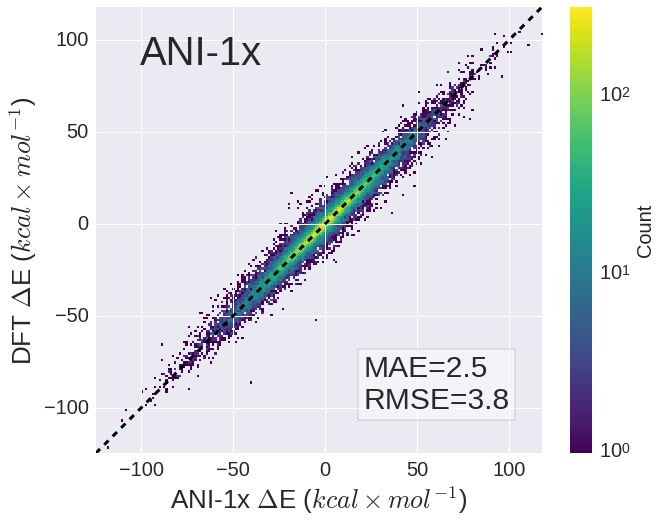

In [17]:
storepath = '/home/jujuman/Dropbox/ANAKIN-ME-RESEARCH/PUBLICATION-ActiveLearning/Figures/denergy_ANIMD_compare.pdf'

label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

#'$F_{dft}$' + r' $(kcal \times mol^{-1} \times \AA^{-1})$'

fig, axes = plt.subplots(1, 1, figsize=[10,8])
cmap = mpl.cm.viridis

bin1 = aes.plot_corr_dist_axes(axes, forces['ANI']['Atazanavir'], forces['DFT']['Atazanavir'], cmap, r'ANI-1x $\Delta$E ($kcal \times mol^{-1}$)', r'DFT $\Delta$E ($kcal \times mol^{-1}$)','ANI-1x')

cb1 = fig.colorbar(bin1[-1], cmap=cmap)
cb1.set_label('Count', fontsize=20)

#aes.add_inset_histogram(Forces['ANI'], Forces['DFT'], pos=[0.15, 0.636, .07, .235], ylim=[0, 1200], xlim=[-25, 25])
#aes.add_inset_histogram(Forces['DFTB'], Forces['DFT'], pos=[0.41, 0.636, .07, .235], ylim=[0, 1200], xlim=[-25, 25])
#aes.add_inset_histogram(Forces['PM6'], Forces['DFT'], pos=[0.67, 0.636, .07, .235], ylim=[0, 1200], xlim=[-25, 25])
#add_inset_histogram(ax, Xa, Xp)
#add_inset_histogram(ax, Xa, Xp)

plt.show()
#pp = PdfPages(storepath)
#pp.savefig(fig)
#pp.close()

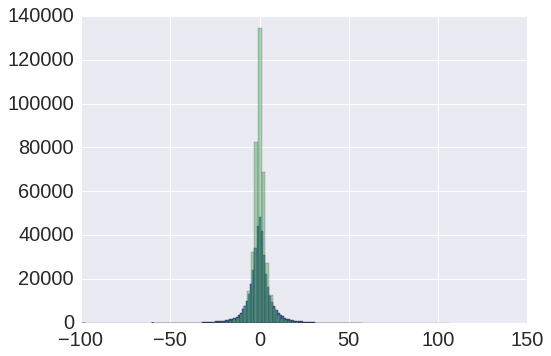

In [14]:
plt.hist(Forces['DFTB'] - Forces['DFT'],bins=100)
plt.hist(Forces['ANI'] - Forces['DFT'],bins=100, alpha=0.5)

plt.show()

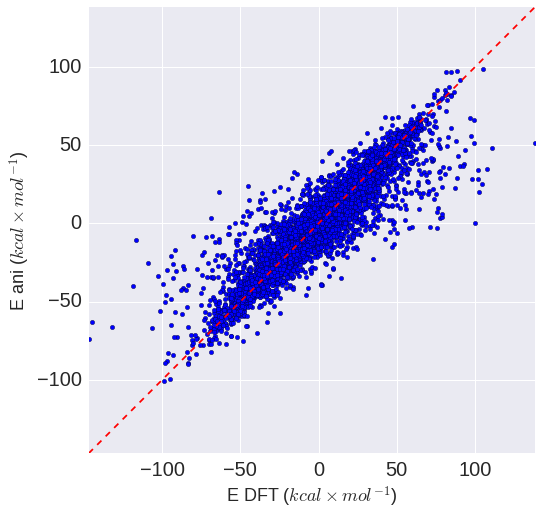

In [15]:
Ed = forces['DFT']['Retinol']
Ea = forces['ANI']['Retinol']

fig = plt.figure(figsize=[8,8])
plt.scatter(Ed, Ea)
plt.plot([Ed.min(), Ed.max()], [Ed.min(), Ed.max()],'--',c='r')
plt.xlim([Ed.min(), Ed.max()])
plt.ylim([Ed.min(), Ed.max()])
plt.xlabel(r"E DFT ($kcal \times mol^{-1}$)", fontsize=18)
plt.ylabel(r"E ani ($kcal \times mol^{-1}$)", fontsize=18)
plt.show()
#pp = PdfPages("/home/jujuman/Dropbox/ANAKIN-ME-RESEARCH/Figures/NEW-11-30-17/fent_ecorr_plot.pdf")
#pp.savefig(fig)
#pp.close()